# Imports

In [2]:
%load_ext autoreload
%autoreload

import os, sys

modules = os.path.abspath(os.path.join("..", "src"))
sys.path.append(modules)

import polars as pl
from transformers import AutoModel, AutoTokenizer
import nlp_utils, keywords_utils, load_utils, run_analysis
from config import *


/home/msalvetti/notebooks_2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-17 15:35:27.697644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Attempts

In [3]:
lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url", "text")

MAX_CHARS = 10 * 1024
lf = lf.filter(pl.col("text") != "").with_columns(
    [pl.when(pl.col("text").str.len_chars() > MAX_CHARS)
     .then(pl.col("text").str.slice(0, MAX_CHARS))
     .otherwise(pl.col("text")).alias("text")]
)
lf = lf.filter(pl.col("text")!= "")\
.filter(~pl.col("text").str.starts_with("Powered by Imunify360")).unique("text")\
.filter(~pl.col("text").str.contains("Loader Please wait while your request is being verified..."))\
.filter(~pl.col("text").str.contains("You need to enable JavaScript to run this app"))\
.filter(~pl.col("text").str.contains("flex-basis: "))\
.filter(~pl.col("text").str.contains("document.getElementById"))

lf.sink_parquet(pl.PartitionMaxSize("split_dataset/", max_size=3000), mkdir=True)

File ARGUS_chunk_p183.parquet is corrupted


In [6]:
import glob
from pathlib import Path
import gc
import pyarrow as pa
import pyarrow.parquet as pq
import time
from datetime import timedelta
import os
from multiprocessing import Pool
import psutil
from typing import List
from sentence_transformers import SentenceTransformer

os.environ["TOKENIZERS_PARALLELISM"] = "true"


MODEL_ID = "sentence-transformers/distiluse-base-multilingual-cased-v1"
MODEL_ID = "google/embeddinggemma-300m"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize(t):
    return tokenizer(t, padding = 'max_length', max_length = 1024, truncation = True, return_tensors = "pt").data
    

mem: List[str] = []

i = 0
out_path = Path("out_gemma")
out_path.mkdir(exist_ok=True)
n_files = len(glob.glob("output/000*.parquet"))
start = time.time()

with open("memory_usage.txt", "w+") as f:
    f.write("")

for path in glob.glob("output/000*.parquet"):
    i += 1
    df = pl.read_parquet(path).unique("text")
    texts = df["text"].to_list()
    urls = df["url"].to_list()
    toks = tokenize(texts)

    table = pl.DataFrame(toks)
    table = table.with_columns(pl.Series(name = "url", values = urls))
    out_name = out_path / f"tokens_{i:09d}.parquet"
    table.write_parquet(out_name)
    end = time.time()
    eta = timedelta(seconds = (((end - start) / (i/n_files)) - (end - start)))
    process = psutil.Process()
    mem.append(process.memory_info().rss / 1024 / 1024)

    if (i%10 == 0):
        print(f"Done {(i*100/n_files):.1f}%, ({i} / {n_files})")
        print(f"ETA: {eta}")
        print(f"Memory usage: {process.memory_info().rss / 1024 / 1024} MB")
        print(f'Done file {path}')
    
    if (i%100 == 0): 
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding = 'max_length', max_length = 1024, truncation = True, use_fast = True)
        with open("memory_usage.txt", "a") as f:
            f.write(",".join(str(m) for m in mem))
            mem = []

    del table, texts, toks
    gc.collect()
    

Done 2.6%, (10 / 391)
ETA: 0:22:29.241999
Memory usage: 11695.1484375 MB
Done file output/00000106.parquet
Done 5.1%, (20 / 391)
ETA: 0:21:47.517504
Memory usage: 11705.70703125 MB
Done file output/0000012a.parquet
Done 7.7%, (30 / 391)
ETA: 0:21:48.630623
Memory usage: 11661.01953125 MB
Done file output/00000055.parquet
Done 10.2%, (40 / 391)
ETA: 0:20:47.259243
Memory usage: 11678.9453125 MB
Done file output/00000000.parquet
Done 12.8%, (50 / 391)
ETA: 0:20:10.132223
Memory usage: 11676.15234375 MB
Done file output/000000c5.parquet
Done 15.3%, (60 / 391)
ETA: 0:19:31.057383
Memory usage: 11680.83984375 MB
Done file output/000000f8.parquet
Done 17.9%, (70 / 391)
ETA: 0:18:43.938800
Memory usage: 11681.8125 MB
Done file output/00000130.parquet
Done 20.5%, (80 / 391)
ETA: 0:18:00.093517
Memory usage: 11682.23046875 MB
Done file output/0000011e.parquet
Done 23.0%, (90 / 391)
ETA: 0:17:19.070963
Memory usage: 11690.375 MB
Done file output/00000138.parquet
Done 25.6%, (100 / 391)
ETA: 0:16

Text(0.5, 0, 'Time')

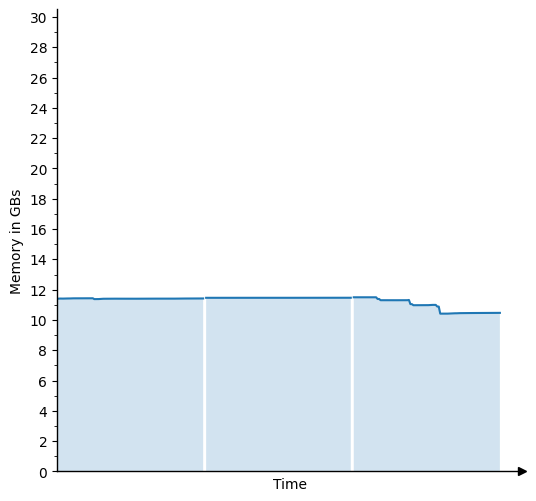

In [11]:
with open("memory_usage.txt") as f:
    mem = f.read()
mem = mem.split(",")

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

plt.style.use("./style.mplstyle")
plot = pd.DataFrame({"mem": mem})

plot["time"] = plot.index
plot["time"] = pd.to_numeric(plot["time"], errors="coerce")
plot["mem"]  = pd.to_numeric(plot["mem"], errors="coerce")
plot["mem"] = plot["mem"] / 1024

fig = plt.figure(figsize=(6,6))
ax = plt.subplot()
plt.plot("time", "mem", data = plot)
ax.set_xlim(0)
ax.set_ylim(0,30.5)
ax.set_xticks([])
# ax.xaxis.set_major_locator(MultipleLocator(100))
# ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on = False)
ax.fill_between(x = "time", y1="mem", y2=0, data = plot, alpha = 0.2)
plt.ylabel("Memory in GBs")
plt.xlabel("Time")

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

lf = pl.scan_parquet("out/tokens*.parquet")

In [3]:
texts = lf.select('input_ids').collect(engine = "streaming")["input_ids"].to_list()

In [34]:
embed = model.get_input_embeddings()

def get_tokens(lf, chunk_size):
    n_rows = lf.select(pl.len()).collect(engine = "streaming").item()
    for i in range(0, n_rows, chunk_size):
        tokens = lf.slice(i, chunk_size).select("input_ids").collect(engine = "streaming")["input_ids"].to_list()
        embs = embed(torch.tensor(tokens, dtype = torch.long))
        frame = pl.DataFrame({'embedding': embs})
        frame.write_parquet(f"embedding_{i}.parequt")

        del tokens, embs, frame
        gc.collect()

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

f = pq.read_table("output/00000000.parquet")
texts = f.to_pydict()["text"]

MODEL_ID = "sentence-transformers/distiluse-base-multilingual-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize(t):
    return tokenizer(t, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt")

In [20]:
toks = tokenize(texts)

In [ ]:
toks["input_ids"]

torch.Tensor

In [ ]:
from transformers import AutoModel
from sentence_transformers import SentenceTransformer
import torch

model = AutoModel.from_pretrained(MODEL_ID)

TypeError: 'str' object cannot be interpreted as an integer

In [34]:
df = pl.read_parquet("out/tokens_000000001.parquet")["input_ids"].to_list()

In [58]:
import torch
import pyarrow as pa
import pyarrow.parquet as pq

f = pq.read_table("output/00000000.parquet")
texts = f.to_pydict()["text"]

enc = tokenizer(texts,return_tensors="pt", truncation = True, padding = True)

with torch.no_grad():
    model(**enc)

KeyboardInterrupt: 

# Make some order

Basically I want the whole output of the tokenizer, then pass it to model()

In [69]:
import pyarrow as pa
import pyarrow.parquet as pq
from transformers import AutoModel, AutoTokenizer


f = pq.read_table("output/00000000.parquet")
texts = f.to_pydict()["text"][0:10]

MODEL_ID = "sentence-transformers/distiluse-base-multilingual-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize(t):
    return tokenizer(t, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt")

toks = tokenize(texts)

At this point we have tokens, now we need embeddings

In [78]:
from transformers import AutoModel, AutoTokenizer
import transformers
from sentence_transformers import SentenceTransformer
import torch

model = AutoModel.from_pretrained(MODEL_ID)
input_ids = torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["input_ids"])
attention_mask = torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["attention_mask"])
toks = transformers.tokenization_utils_base.BatchEncoding({"input_ids": input_ids, "attention_mask": attention_mask})

with torch.no_grad():
    output = model(**toks)

sentence_embeddings = output.last_hidden_state[:, 0, :].numpy()


KeyboardInterrupt: 

Ok this works. Now we only want to write the tokens to a file and be able to retrieve them as a transformers.tokenization_utils_base.BatchEncoding type

In [50]:
df2 = pl.read_parquet("out/tokens_000000001.parquet")

In [77]:
torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["input_ids"])
torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["attention_mask"])

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

# ASPI categories

In [2]:
import polars as pl

%load_ext autoreload
%autoreload

import os, sys

modules = os.path.abspath(os.path.join("..", "src"))
sys.path.append(modules)

import torch
from transformers import AutoModel, AutoTokenizer
import nlp_utils
from config import *

categories = pl.read_parquet(DATA_DIR + "processed/aspi_categories.parquet")["description"].to_list()

2025-12-15 14:14:39.782426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from transformers import AutoTokenizer

MODEL_ID = "sentence-transformers/distiluse-base-multilingual-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize(t):
    return tokenizer(t, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt")

toks = tokenize(categories)

In [8]:
pl.DataFrame(toks.data)

input_ids,attention_mask
"array[i64, 512]","array[i64, 512]"
"[101, 26745, … 0]","[1, 1, … 0]"
"[101, 26745, … 0]","[1, 1, … 0]"
"[101, 26745, … 0]","[1, 1, … 0]"
"[101, 38392, … 0]","[1, 1, … 0]"
"[101, 13828, … 0]","[1, 1, … 0]"
…,…
"[101, 65136, … 0]","[1, 1, … 0]"
"[101, 42491, … 0]","[1, 1, … 0]"
"[101, 12395, … 0]","[1, 1, … 0]"


In [8]:
tokens = pl.DataFrame(toks.data)

In [10]:
tokens.write_parquet("tokens_aspi.parquet")